# Galaxy Classification, Anomaly Detection, Autoencoder & VAE (Keras)
This notebook uses the Galaxy10 DECaLS dataset (astronomical galaxy images) for:

1. Data loading & splitting, defining an anomaly class  
2. CNN classifier + ROC curves & confusion matrices  
3. Convolutional autoencoder for anomaly detection  
4. Variational autoencoder (VAE) + galaxy generation

Dataset: Galaxy10 DECaLS (HDF5).


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random, models

import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## 1. Download the dataset, inspect classes, create anomaly split

Steps:
- Download `Galaxy10_DECals_64.h5`
- Load images and labels with `h5py`
- Inspect shape and class distribution
- Remove class 4 and store it as the anomaly dataset
- Split remaining (standard) data into train (50%), val (25%), test (25%)

In [ ]:
# Download Galaxy10 DECaLS (HDF5)
! rm ./Galaxy10_DECals_64.h5
! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
data_path = "./Galaxy10_DECals_64.h5"

print("Downloaded to:", data_path)


In [ ]:
# Copy data onto drive s.t. dont need to download every time
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

# Pfade
drive_path = Path("/content/drive/MyDrive/Galaxy10_DECals_64.h5")
local_path = Path("./Galaxy10_DECals_64.h5")

#!cp "./Galaxy10_DECals_64.h5" "/content/drive/MyDrive/Galaxy10_DECals_64.h5"

# 1. case: data not on google drive
if not drive_path.exists():
    print("start download from cern...")
    !wget -O "{drive_path}" https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
    print("finished download from cern!")
else:
    print("dataset already on google drive")

# 2. case: data on google drive
if not local_path.exists():
    print("copy data from google drive into colab")
    !cp "{drive_path}" "{local_path}"
else:
    print("data already in colab")

# Endgültiger Pfad für den Rest deines Codes
data_path = "./Galaxy10_DECals_64.h5"
print(f"Data path: {data_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset already on google drive
data already in colab
Data path: ./Galaxy10_DECals_64.h5


In [ ]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images/255

print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)

Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8


In [ ]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

Class distribution:
Class 0 (Disturbed Galaxies): 1081
Class 1 (Merging Galaxies): 1853
Class 2 (Round Smooth Galaxies): 2645
Class 3 (In-between Round Smooth Galaxies): 2027
Class 4 (Cigar Shaped Smooth Galaxies): 334
Class 5 (Barred Spiral Galaxies): 2043
Class 6 (Unbarred Tight Spiral Galaxies): 1829
Class 7 (Unbarred Loose Spiral Galaxies): 2628
Class 8 (Edge-on Galaxies without Bulge): 1423
Class 9 (Edge-on Galaxies with Bulge): 1873


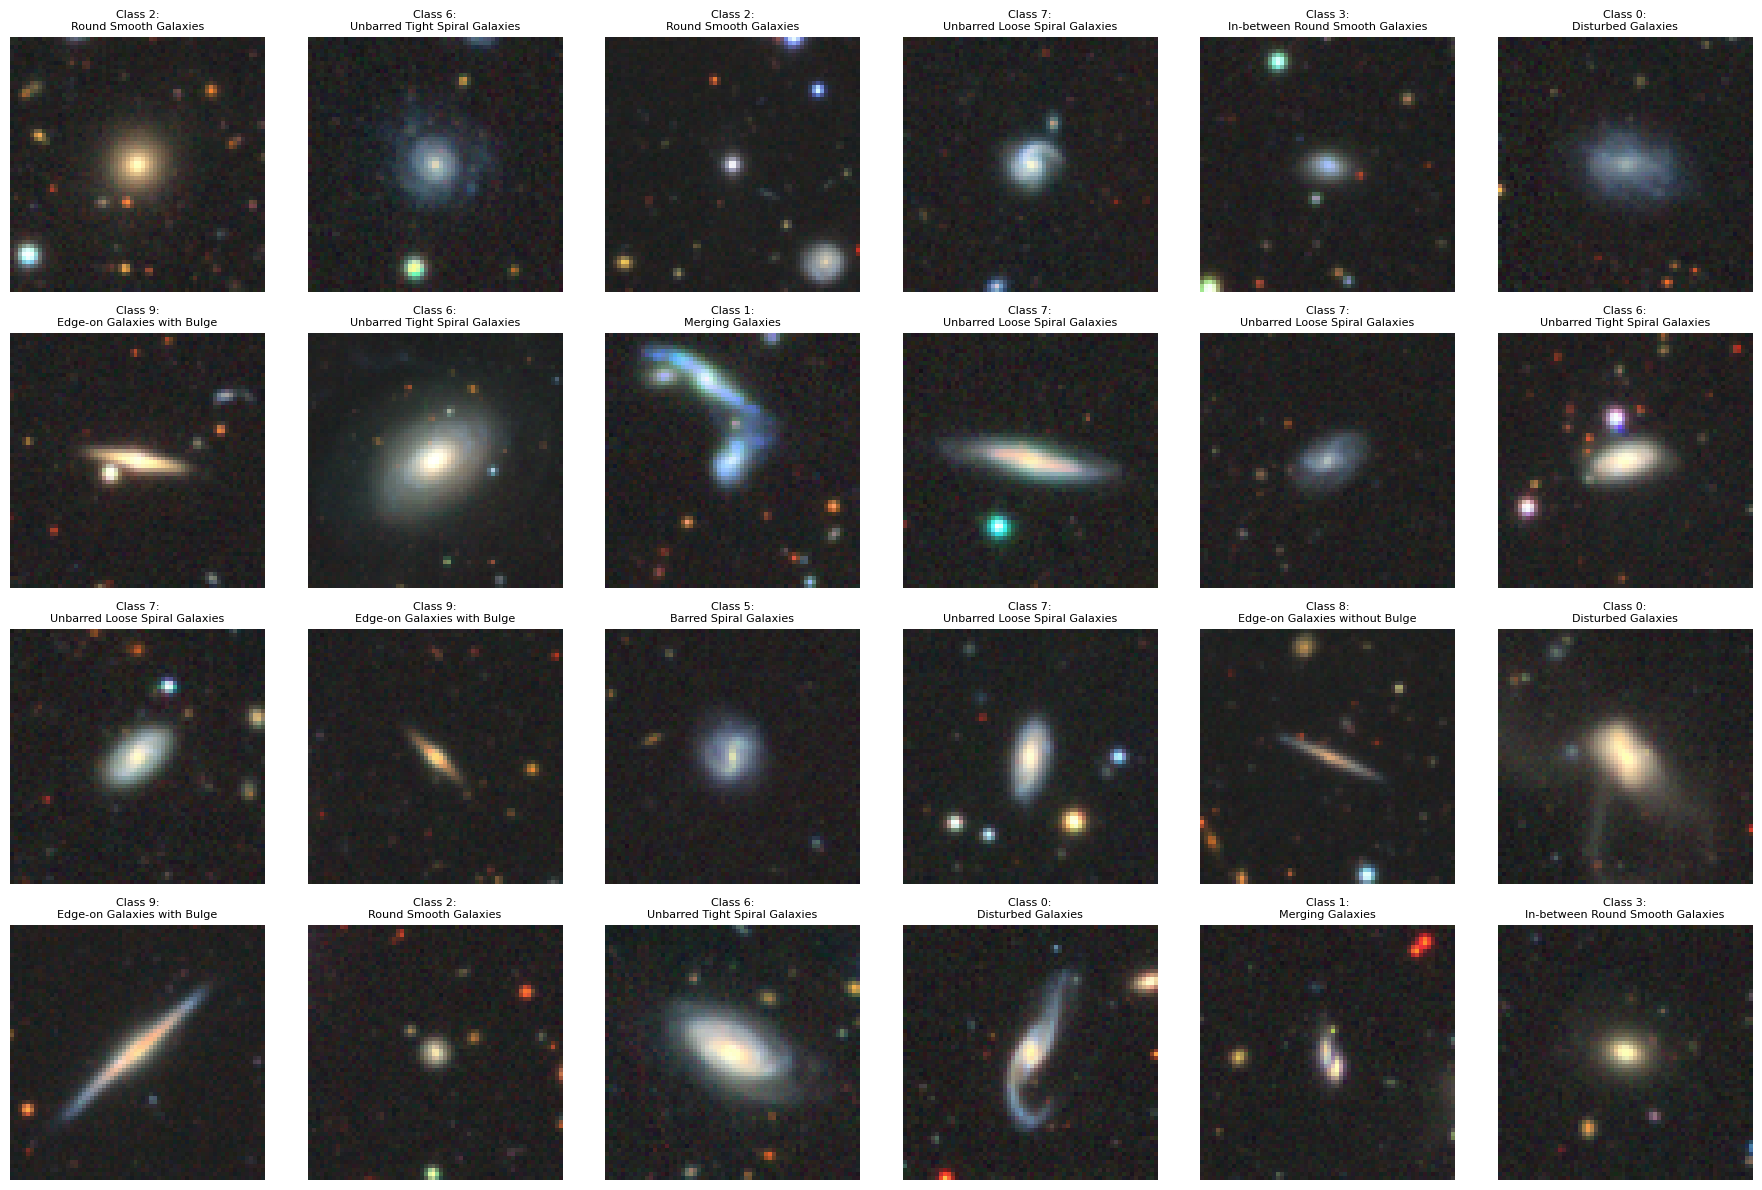

In [ ]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=4, n_cols=6):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [ ]:
# Create anomaly dataset: all class 0 images
ANOMALY_CLASS = 0

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 0, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (16655, 64, 64, 3)
Anomaly images: (1081, 64, 64, 3)


In [ ]:
# For training, remap standard labels from {0,1,2,3,5,6,7,8,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

Standard classes (original indices): [np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]
Label map (original -> new): {np.uint8(1): 0, np.uint8(2): 1, np.uint8(3): 2, np.uint8(4): 3, np.uint8(5): 4, np.uint8(6): 5, np.uint8(7): 6, np.uint8(8): 7, np.uint8(9): 8}
Remapped standard labels min/max: 0 8


In [ ]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

Train standard: (8327, 64, 64, 3) (8327,)
Val standard:   (4164, 64, 64, 3) (4164,)
Test standard:  (4164, 64, 64, 3) (4164,)


In [ ]:
from keras.src.utils import to_categorical

# Convert labels into one-hot encoding
y_train_enc = to_categorical(y_train_std, 9)
y_val_enc = to_categorical(y_val_std, 9)
y_test_enc = to_categorical(y_test_std, 9)

print(y_train_enc[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1.]


## 4. Variational Autoencoder (VAE) on standard data

Steps:
- Build a VAE with convolutional encoder/decoder (trained on standard train set)
- Plot training history
- Generate new galaxy images from the VAE
- Visualize some generated images

In [ ]:
# Add Sampling class such that we have a possibility to differentiate in Training (mü+sigma*epsilon, epsilon from N(0,I))
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Define Encoder and Decoder
latent_dim = 128      # bigger = less stable training, smaller = few variation (too much info lost)
img_dim = (64, 64, 3)

# Encoder
encoder_inputs = keras.Input(shape=img_dim)

# first layer
x = layers.Conv2D(32, (3, 3), strides=1, padding="same")(encoder_inputs)
#x = layers.BatchNormalization()(x)   # Removed because makes variance between batches similar --> averages different galaxies feature togetehr
x = layers.Activation("relu")(x)

# second layer 64x64 --> 32x32
x = layers.Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = layers.Activation("relu")(x)

# third layer 32x32 --> 16x16
x = layers.Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = layers.Activation("relu")(x)

# fourth layer
x = layers.Conv2D(64, (3, 3), activation="relu", strides=1, padding="same")(x)  # Get some more structure

# normal distribution space
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)   # bottleneck dim=512
x = layers.Dropout(0.2)(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)         # mean/variance estimation of picture distribution
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)

# first layer
x = layers.Conv2D(64, (3, 3), padding="same")(x)
x = layers.Activation("relu")(x)

# second decoder layer 16x16 --> 32x32
x = layers.Conv2D(64, (3, 3), strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.UpSampling2D((2, 2))(x)    # Known problem of artifacts when using Conv2DTranspose (overlapping regions)

# third decoder layer 32x32 --> 64x64
x = layers.Conv2D(128, (3, 3), strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.UpSampling2D((2, 2))(x)

# fourth decoder layer
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)

decoder_outputs = layers.Conv2D(3, (3, 3), padding="same", activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 64, 64,    │        896 │ input_layer_18[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 64, 64,    │          0 │ conv2d_96[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 32, 32,    │      9,248 │ activation_65[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 32, 32,    │          0 │ conv2d_97[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 16, 16,    │     18,496 │ activation_66[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_67       │ (None, 16, 16,    │          0 │ conv2d_98[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 16, 16,    │     36,928 │ activation_67[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 16384)     │          0 │ conv2d_99[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 512)       │  8,389,120 │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │     65,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │     65,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_9          │ (None, 128)       │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,586,016 (32.75 MB)

 Trainable params: 8,586,016 (32.75 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_68 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_69 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_21 (UpSampling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_70 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_22 (UpSampling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,336,771 (8.91 MB)

 Trainable params: 2,336,771 (8.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# VAE Class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # BCE reconstruction loss (penetalizes wrong direction bright/dark pixels between [0,1] more into correct direction (not symmetric lke MSE)
            reconstruction_loss = ops.mean(ops.sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.beta * kl_loss    # introduced beta hyperparameter (battle against posterior colapse)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [ ]:
# construct the VAE model
vae = VAE(encoder, decoder, 0.075)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
# training VAE model
vae_fit = vae.fit(X_train_std, epochs=30, batch_size=128)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - kl_loss: 31.0733 - loss: 1725.0563 - reconstruction_loss: 1722.7256
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - kl_loss: 47.5932 - loss: 1715.3549 - reconstruction_loss: 1711.7853
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - kl_loss: 52.5730 - loss: 1713.3066 - reconstruction_loss: 1709.3635
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - kl_loss: 54.8968 - loss: 1713.5990 - reconstruction_loss: 1709.4821
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - kl_loss: 56.1430 - loss: 1715.3434 - reconstruction_loss: 1711.1327
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - kl_loss: 57.0087 - loss: 1711.9822 - reconstruction_loss: 1707.7065
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - kl_loss: 57.5985 - loss: 1712.3042 - reconstruction_loss: 1707.9844
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - kl_loss: 58.5335 - loss: 1712.4672 - reconstruction_loss: 1708.0770
Epoch 9/30
66/66 ━━━━━━━━━━━━

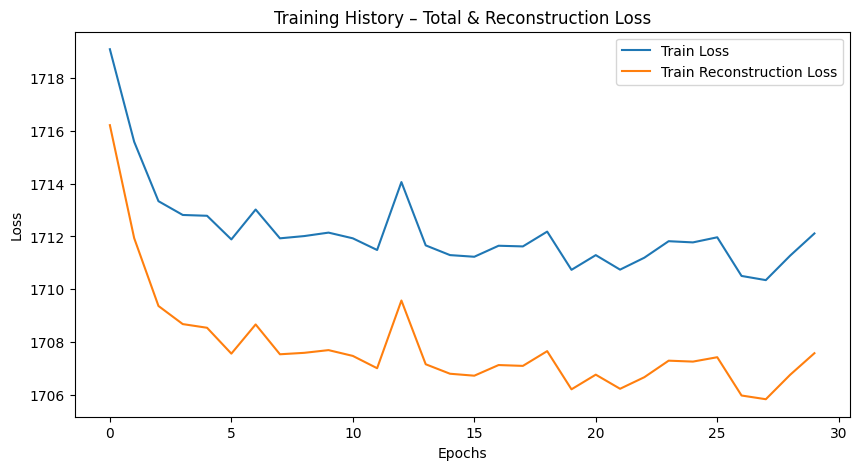

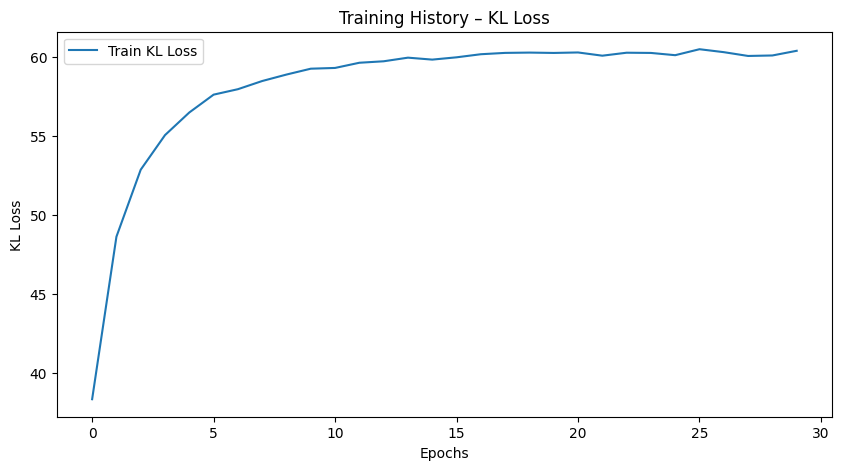

In [ ]:
# plot training history

# Plot 1: Reconstruction + Total Loss
plt.figure(figsize=(10, 5))
plt.plot(vae_fit.history['loss'], label='Train Loss')
plt.plot(vae_fit.history['reconstruction_loss'], label='Train Reconstruction Loss')
plt.title('Training History – Total & Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot 2: KL Loss
plt.figure(figsize=(10, 5))
plt.plot(vae_fit.history['kl_loss'], label='Train KL Loss')
plt.title('Training History – KL Loss')
plt.xlabel('Epochs')
plt.ylabel('KL Loss')
plt.legend()
plt.show()


In [ ]:
# BCE high because minimum dont have to be at 0 and we sum over all pixels
# stable KL Loss indicates that gaussian prior has its effect
# good balance --> ~0.5 nits per dimension --> encodes enough info about galaxy features but still near N(0,I)

In [ ]:
def generate_random_images(decoder, latent_dim, n=10, rows=2):
    # Sample random points in the latent space
    z_random = np.random.normal(size=(n, latent_dim))

    # Decode them into images
    generated = decoder.predict(z_random)

    cols = int(np.ceil(n / rows))

    # Plot
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        img = generated[i].squeeze()
        plt.imshow(img)
        plt.axis("off")
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


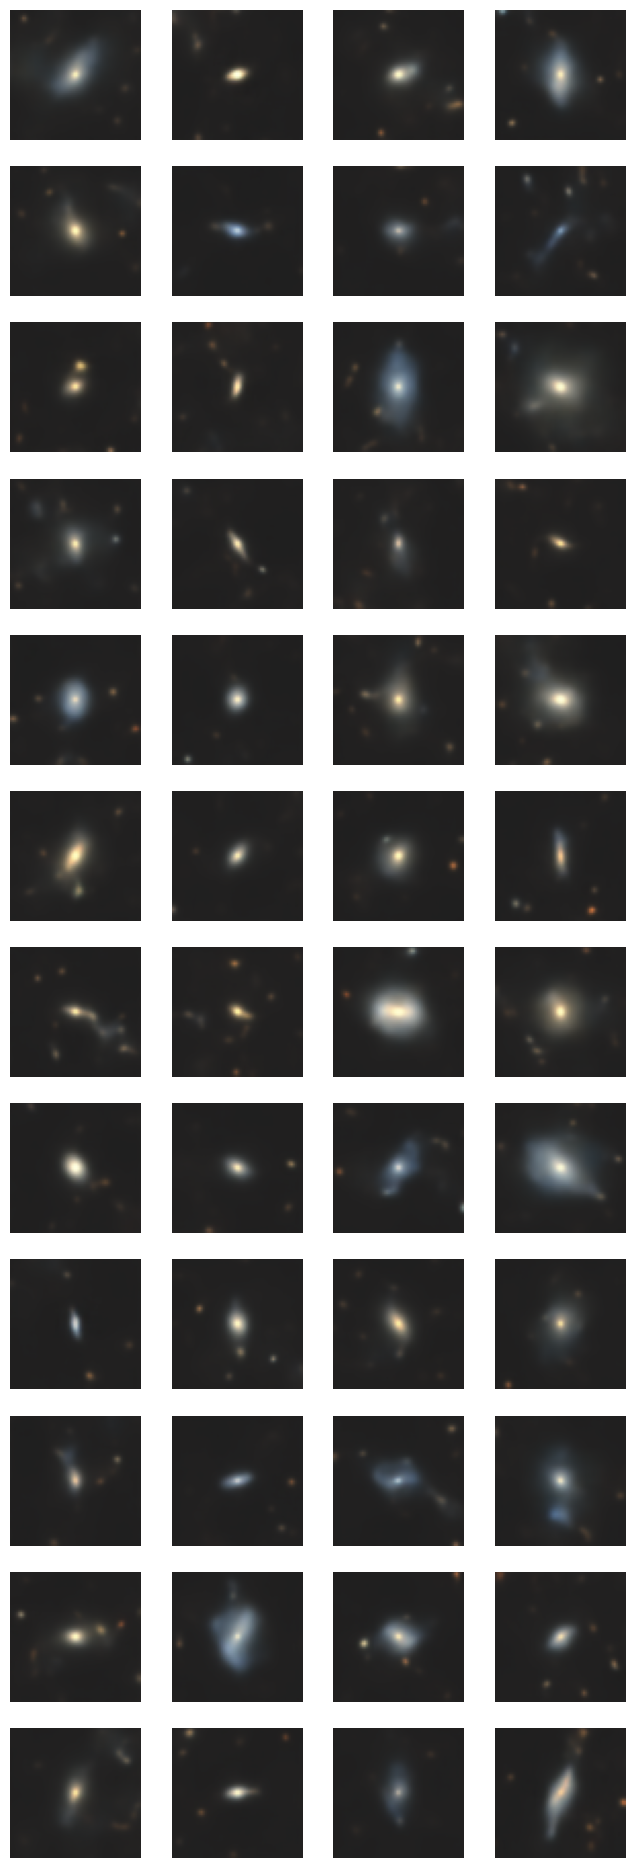

In [ ]:
# generate and visualize generated galaxy images
generate_random_images(decoder, latent_dim=latent_dim, n=48, rows=12)